# **Group Report**

# TODO
- Decide with backward or forward selection
- report accuracy metric using worksheet 13 material
- Remove ggpairs plot in EDA as it is too large and provides little explanation: Be sure to not print output that takes up a lot of screen space.
- Rewording and rewrite
- Update discussion

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
library(broom)
library(leaps)
library(cowplot)
library(GGally)
library(AER)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## **Intro**

### **Question**

Knowing the age distribution of a company's workforce helps employers plan the workplace culture and the hiring of new staff (Gao et al., 2018). Further, being able to predict an employee's age is a possible way to assess the overall performance of the company (Shore et al, 2003). As such, we aim to find how accuractely can age be predicted using a linear regression of the optimally selected features of an employee dataset. Then, we plan on quantifying its effectiveness and evaluating its adherence to our linear model assumptions.

Data sourced from https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

### **Description**

This dataset contains personal data from 4653 employees from a company with locations across India. For each employee it contains the following information: Education, JoiningYear, City, PaymentTier, Age, Gender, EverBenched, ExperienceInCurrentDomain, LeaveOrNot. There are no missing values from any of these columns in the dataset. 

- `Education` is a categorical/ordinal variable with levels: Bachelors, Masters, PHD. A vase majority of employees only have a Bachelors while only a few of a PhD.
- `JoiningYear` is a quantitative variable with range from 2012 to 2018, having both a mean and median of 2015.
- `City` is a categorical variable with levels: Bangalore, Pune, and New Delhi. Around half of employees work in Bangalore while the other half are split between New Delhi and Pune. 
- `PaymentTier` is a categorical and possibly ordinal variable with levels: 1, 2, 3. 3 is by far the most abundant and 1 is the least.
- `Age` is a quantitative variable with range 22-41 with mean 29.39 and median 28.
- `Gender` is a qualitative variable with levels: Male and Female. There are 1875 Females and 2778 Males.
- `Everbenched` is a binary qualitative variable with levels: yes and no. Only 478 of 4653 have ever been benched.
- `ExperienceInCurrentDomain` is a quantitative variable with a range from 0-7 years. The mean and median are both close to 3.
- `LeaveOrNot` is a binary qualitative variable with levels 0 or 1. 1600 or around a third are 1, the rest are 0.


<br>

## **Methods and Results**

### **EDA**

#### **Loading Data**

We load the data from the web:

In [2]:
employee_data <- read_csv("https://raw.githubusercontent.com/zhtgeneral/stat-301-data/main/Employee.csv", show_col_types = FALSE)
head(employee_data, 1)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0


In [3]:
nrow(employee_data)

[1] 4653

In [4]:
sum(is.na(employee_data))

[1] 0

<br>

#### **Reshaping data**

We make our categorical variables as factors for analysis and to ensure they are properly interpreted by the model we create.

In [5]:
employee_data$Education   = factor(employee_data$Education)
employee_data$City        = factor(employee_data$City)
employee_data$PaymentTier = factor(employee_data$PaymentTier)
employee_data$Education   = factor(employee_data$Education)
employee_data$Gender      = factor(employee_data$Gender)
employee_data$EverBenched = factor(employee_data$EverBenched)
employee_data$LeaveOrNot  = factor(employee_data$LeaveOrNot)
employee_data |> head(1)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Bachelors,2017,Bangalore,3,34,Male,No,0,0


<br>

#### **Visualization**

We explore the association of the explanatory variables with the response below:

We plot the distribution of age to serve as a reference for within group comparisons.

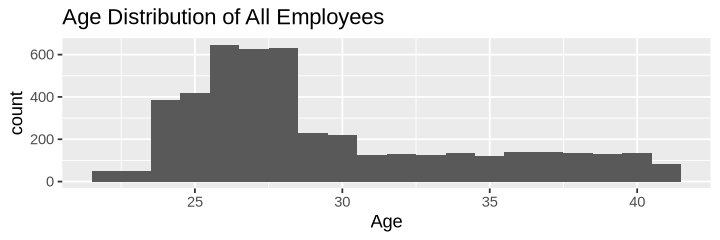

In [6]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(employee_data, aes(x = Age)) + geom_histogram(bins = 20) + xlab("Age") + ggtitle("Age Distribution of All Employees")

<br>

Next, we compare the explanatory variables with Age to detect any correlation.

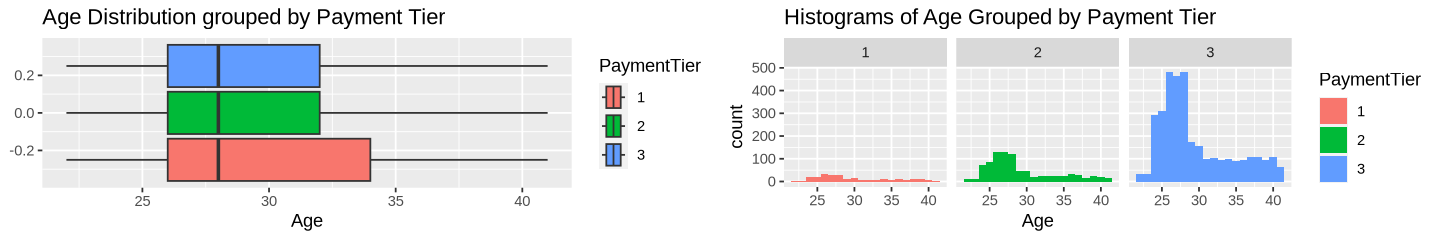

In [7]:
options(repr.plot.width = 12, repr.plot.height = 2)
ap1 <- ggplot(employee_data, aes(Age, fill = PaymentTier)) + geom_boxplot() + ggtitle("Age Distribution grouped by Payment Tier")
ap2 <- ggplot(employee_data, aes(Age, fill = PaymentTier)) + geom_histogram(bins = 20) + facet_grid(.~PaymentTier) + ggtitle("Histograms of Age Grouped by Payment Tier")
plot_grid(ap1, ap2, ncol = 2)

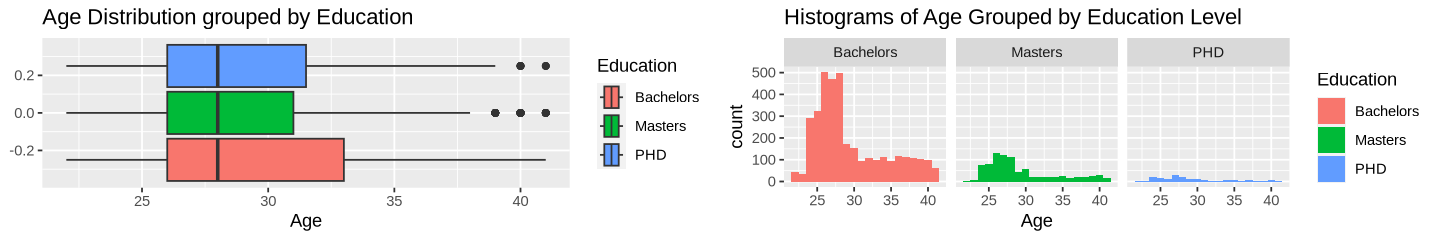

In [8]:
ae1 <- ggplot(employee_data, aes(Age, fill = Education)) + geom_boxplot() + ggtitle("Age Distribution grouped by Education")
ae2 <- ggplot(employee_data, aes(Age, fill = Education)) + geom_histogram(bins=20) + facet_grid(.~Education) + ggtitle("Histograms of Age Grouped by Education Level")
plot_grid(ae1, ae2, ncol = 2)

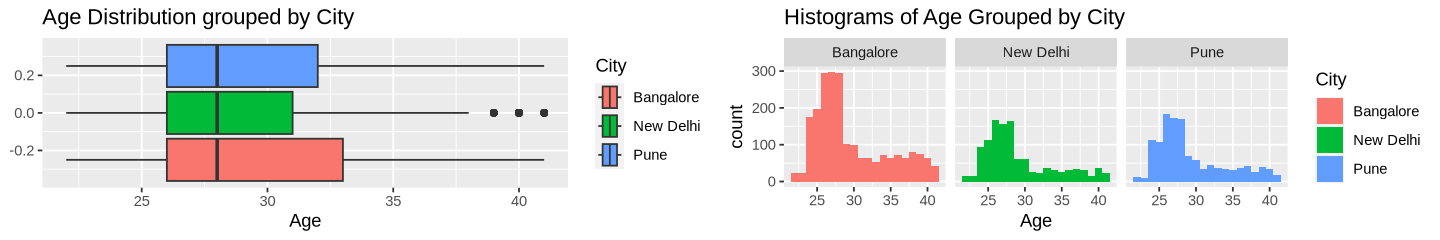

In [9]:
ac1 <- ggplot(employee_data, aes(Age, fill = City)) + geom_boxplot() + ggtitle("Age Distribution grouped by City")
ac2 <- ggplot(employee_data, aes(Age, fill = City)) + geom_histogram(bins = 20) + facet_grid(.~City) + ggtitle("Histograms of Age Grouped by City")
plot_grid(ac1, ac2, ncol = 2)

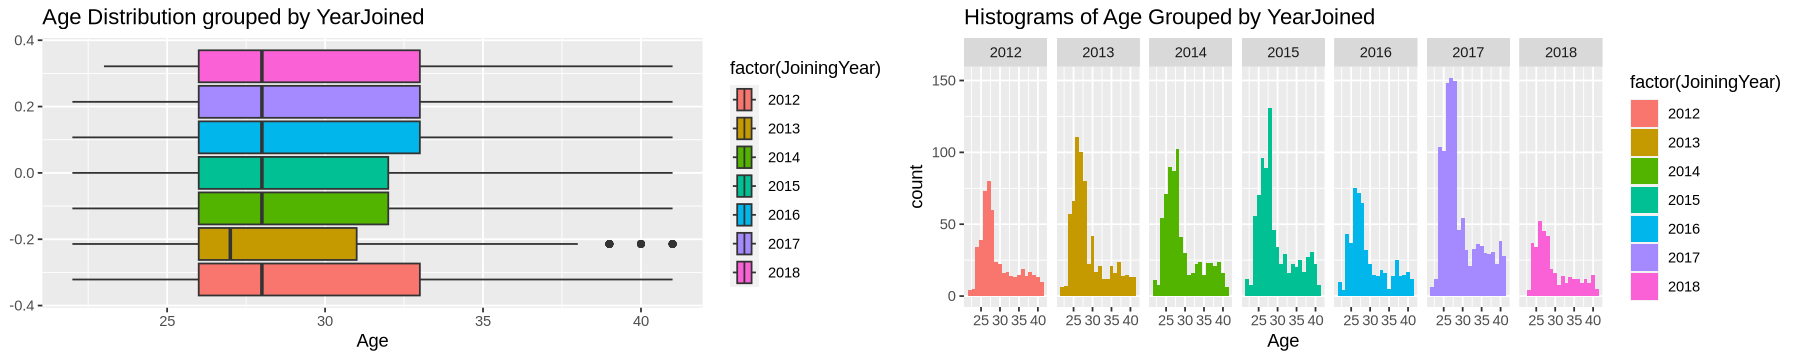

In [10]:
options(repr.plot.width = 15, repr.plot.height = 3)
ay1 <- ggplot(employee_data, aes(Age, fill = factor(JoiningYear))) + geom_boxplot() + ggtitle("Age Distribution grouped by YearJoined")
ay2 <- ggplot(employee_data, aes(Age, fill = factor(JoiningYear))) + geom_histogram(bins = 20) + facet_grid(.~JoiningYear) + ggtitle("Histograms of Age Grouped by YearJoined")
plot_grid(ay1, ay2, ncol = 2)

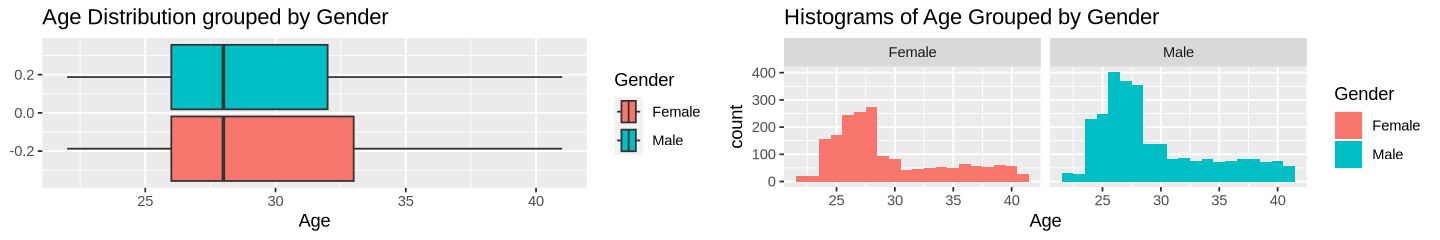

In [11]:
options(repr.plot.width = 12, repr.plot.height = 2)
ag1 <- ggplot(employee_data, aes(Age, fill = Gender)) + geom_boxplot() + ggtitle("Age Distribution grouped by Gender")
ag2 <- ggplot(employee_data, aes(Age, fill = Gender)) + geom_histogram(bins = 20) + facet_grid(.~Gender) + ggtitle("Histograms of Age Grouped by Gender")
plot_grid(ag1, ag2, ncol = 2)

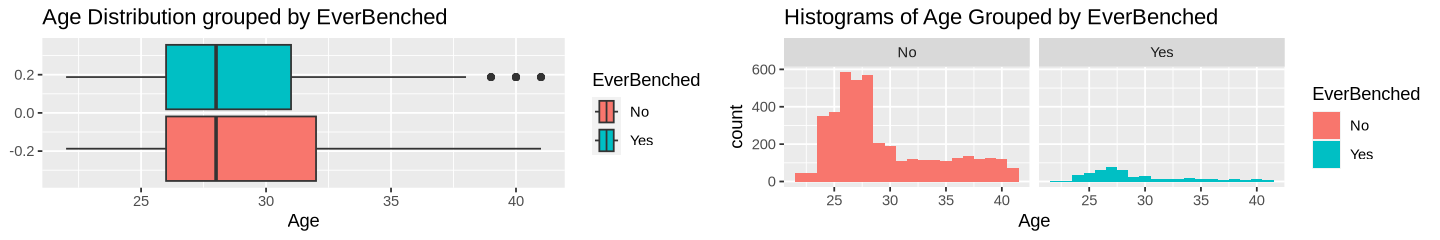

In [12]:
ab1 <- ggplot(employee_data, aes(Age, fill = EverBenched)) + geom_boxplot() + ggtitle("Age Distribution grouped by EverBenched")
ab2 <- ggplot(employee_data, aes(Age, fill = EverBenched)) + geom_histogram(bins = 20) + facet_grid(.~EverBenched) + ggtitle("Histograms of Age Grouped by EverBenched")
plot_grid(ab1, ab2, ncol = 2)

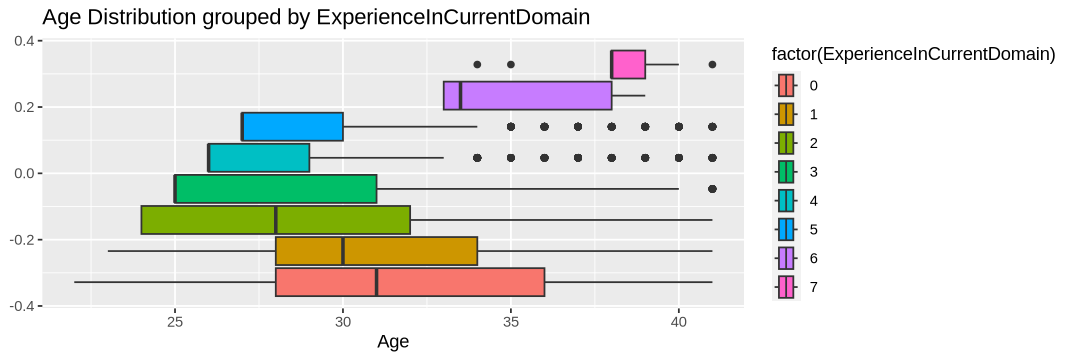

In [13]:
options(repr.plot.width = 9, repr.plot.height = 3)
ax1 <- ggplot(employee_data, aes(Age, fill = factor(ExperienceInCurrentDomain))) + geom_boxplot() + ggtitle("Age Distribution grouped by ExperienceInCurrentDomain")
ax1

We compared each of the explanatory variables with age to detect any correlation. `PaymentTier`, `Education`, `City`, `YearJoined`, `Gender`, `Everbenched` don't seem to have large impact on explaning age when plotted alone. For `ExperienceInCurrentDomain` however, it seems as if higher experience is correlated with increasing age with the exception of mid-age employees switching career domains as they have 0-1 years.

We filter out employees who seem to be switching careers and check the correlation.

[1] -0.1346429

[1] 0.01831297

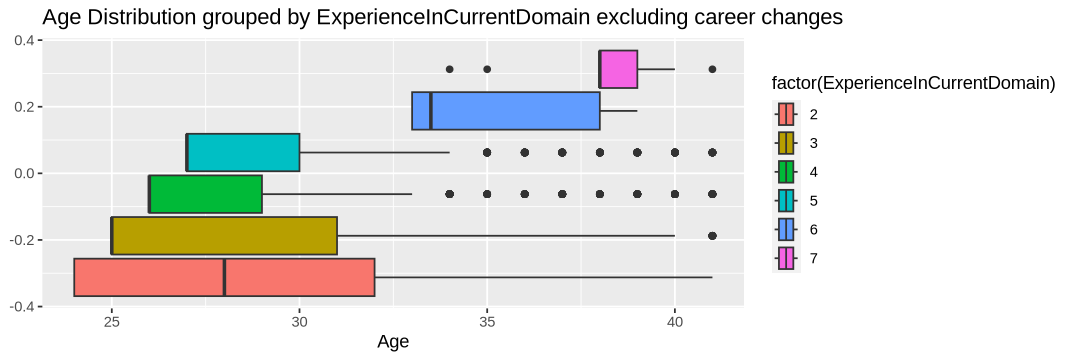

In [14]:
new <- employee_data |> filter(ExperienceInCurrentDomain >= 2)

options(repr.plot.width = 9, repr.plot.height = 3)
nx1 <- ggplot(new, aes(Age, fill = factor(ExperienceInCurrentDomain))) + geom_boxplot() + ggtitle("Age Distribution grouped by ExperienceInCurrentDomain excluding career changes")
nx1

cor(employee_data$Age, employee_data$ExperienceInCurrentDomain)
cor(new$Age, new$ExperienceInCurrentDomain)

It seems like ExperienceInCurrentDomain doesn't explain Age better when we exclude career changes. Perhaps if the data included this feature more results may be shown.

Overall, it seems like the explanatory variables aren't explaining the response very well when plotted alone. We keep all the variables and complete variable selection below.

<br>

## **Method**

Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code that does the analysis.

We use ridge regression to predict an employees age. 
Since Ridge regression performs no variable selection, we use backward selection to remove the least important variable, choosing the number of variables that minimizes $C_p$. 
Minimizing $C_p$ was chosen instead of AIC and BIC, as they penalize complex models and the dimension of our input variables is low.
We split the data to avoid giving bias to our test results and use training for variable selection and test for assessing the model. 
We plan 70% for training and 30% for testing as we want to maximize the accuracy of the model during training.
The model will be assessed using $R^2$ as it represents the proportion of the variation of the response that can be explained with our selected variables.

#### **Splitting the data**

In [15]:
set.seed(123)
employee_split <- initial_split(employee_data, prop = 0.7, strata = PaymentTier)
employee_training <- training(employee_split)
employee_testing  <- testing(employee_split)

head(employee_training, 1)

Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Masters,2017,New Delhi,2,37,Male,No,2,0


<br>

#### **Backward selection**

In [27]:
employee_backward_sel <- regsubsets(x = Age ~ ., nvmax = 11, data = employee_training, method = "backward")

employee_backward_summary <- summary(employee_backward_sel)
employee_backward_summary
print("sdsd")

ERROR: Error in as.data.frame.default(employee_backward_summary): cannot coerce class ‘"summary.regsubsets"’ to a data.frame


In [22]:
employee_backward_summary_df <- tibble(
    n_input_variables = 1:11,
    RSQ    = employee_forward_summary$rsq,
    RSS    = employee_forward_summary$rss,
    ADJ.R2 = employee_forward_summary$adjr2,
    Cp     = employee_forward_summary$cp,
    BIC    = employee_forward_summary$bic,
)
employee_backward_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01615063,72813.61,0.01584828,33.951837,-36.839238
2,0.02237312,72353.09,0.02177206,15.169387,-49.409396
3,0.02399970,72232.71,0.02309933,11.736809,-46.742975
4,0.02508542,72152.36,0.02388589,10.110620,-42.278769
5,0.02618181,72071.22,0.02468363,8.448792,-37.854278
6,0.02702556,72008.77,0.02522874,7.630756,-32.588359
7,0.02770352,71958.60,0.02560805,7.366444,-26.769645
8,0.02818102,71923.26,0.02578664,7.771641,-20.280826
9,0.02841680,71905.81,0.02572294,8.984171,-12.982619


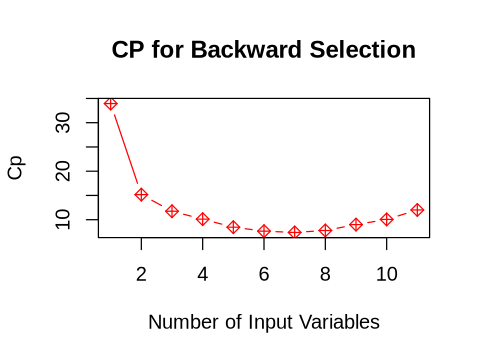

In [23]:
plot(summary(employee_backward_sel)$cp, main = "CP for Backward Selection", xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 9, col = "red")

In [24]:
cp_min_backward_sel = which.min(employee_backward_summary$cp) 
selected_var_backward_sel <- names(coef(employee_backward_sel, cp_min_backward_sel))[-1]
selected_var_backward_sel

[1] "EducationMasters"          "JoiningYear"              
[3] "CityNew Delhi"             "CityPune"                 
[5] "GenderMale"                "ExperienceInCurrentDomain"
[7] "LeaveOrNot1"

<br>

<br>

## **Discussion**

This is my key visualization of the exploratory data analysis. This plot shows the Cp for each of the models trained in the forward selection conducted on the employee training dataset. I ran the forward selection because there were few variables that stood out as being particularly good predictors of age. I chose this visualization as the others were less definitive and explicit. The forward selection identified the features that would produce the best linear model for predicting age. The visualization shows that a minimum Cp is clearly achieved at 7 input variables indicating that this is the optimal amount for the linear model. The Cp at this level is 7.366, since the Cp is close to p=7 it indicates that there is minimal over-fitting and under-fitting. It also clearly illustrates that the inclusion of more variables doesn't necessarily make the model better. With the help of this analysis I was able to identify the 7 best variables and will be using them for my regression model.


**References**

Xiang Gao, Junhao Wen, Cheng Zhang, "An Improved Random Forest Algorithm for Predicting Employee Turnover", Mathematical Problems in Engineering, vol. 2019, Article ID 4140707, 12 pages, 2019. https://doi.org/10.1155/2019/4140707

Shore, L. M., Cleveland, J. N., & Goldberg, C. B. (2003). Work attitudes and decisions as a function of manager age and employee age. Journal of Applied Psychology, 88(3), 529–537. https://doi.org/10.1037/0021-9010.88.3.529